In [29]:
!pip install wandb -q

     |████████████████████████████████| 1.4MB 3.2MB/s 
     |████████████████████████████████| 122kB 10.4MB/s 
     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 163kB 6.0MB/s 
     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 71kB 3.9MB/s 


In [30]:
import wandb

In [31]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [1]:
import glob
import time
import os
import cv2
import base64
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from imageio import imread
from skimage.transform import resize as imresize
from copy import deepcopy
from tqdm import tqdm
import pprint
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
from keras import Input
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.applications import VGG19

In [2]:
!wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip

--2020-08-18 15:19:04--  http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip [following]
--2020-08-18 15:19:05--  https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130688843 (125M) [application/zip]
Saving to: ‘coil-100.zip’

coil-100.zip        100%[===================>] 124.63M  2.81MB/s    in 58s     

2020-08-18 15:20:03 (2.15 MB/s) - ‘coil-100.zip’ saved [130688843/130688843]



In [3]:
!unzip coil-100.zip

Streaming output truncated to the last 5000 lines.
 extracting: coil-100/obj37__280.png  
  inflating: coil-100/obj37__285.png  
  inflating: coil-100/obj37__290.png  
  inflating: coil-100/obj37__295.png  
  inflating: coil-100/obj37__30.png  
  inflating: coil-100/obj37__300.png  
  inflating: coil-100/obj37__305.png  
  inflating: coil-100/obj37__310.png  
  inflating: coil-100/obj37__315.png  
  inflating: coil-100/obj37__320.png  
  inflating: coil-100/obj37__325.png  
  inflating: coil-100/obj37__330.png  
  inflating: coil-100/obj37__335.png  
  inflating: coil-100/obj37__340.png  
  inflating: coil-100/obj37__345.png  
  inflating: coil-100/obj37__35.png  
  inflating: coil-100/obj37__350.png  
  inflating: coil-100/obj37__355.png  
  inflating: coil-100/obj37__40.png  
  inflating: coil-100/obj37__45.png  
  inflating: coil-100/obj37__5.png   
  inflating: coil-100/obj37__50.png  
  inflating: coil-100/obj37__55.png  
  inflating: coil-100/obj37__60.png  
  inflating: coil-100

In [4]:
epochs =4000

batch_size = 16

low_resolution_shape = (32, 32, 3)
high_resolution_shape = (128, 128, 3)

common_optimizer = Adam(0.0002, 0.5)

In [5]:
dir_data = "/content/coil-100/*.png"

In [6]:
def build_vgg():
  input_layer = Input(shape=(128, 128, 3))

  vgg = VGG19(weights="imagenet", include_top=False, input_tensor=input_layer)
  vgg.trainable = False 

  outputs = vgg.layers[9].output


  model = Model(inputs=[input_layer], outputs=[outputs])

  return model

In [7]:
vgg = build_vgg()
vgg.compile(loss='mse', optimizer = common_optimizer, metrics=['accuracy'])
vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_______________________________________________________

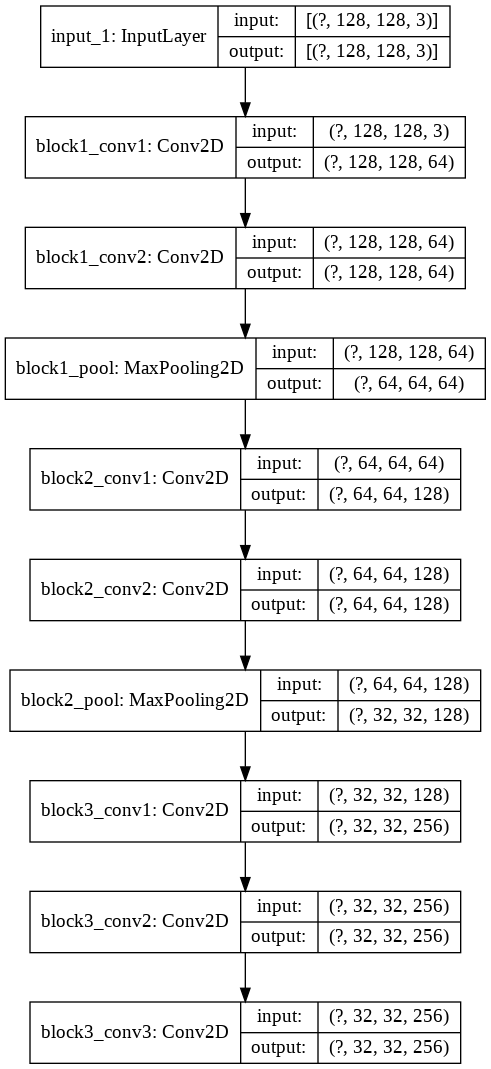

In [8]:
tf.keras.utils.plot_model(vgg, show_shapes=True, show_layer_names=True)

In [9]:
def residual_block(x):
  filters = [64, 64]
  kernel_size = 3
  strides = 1
  padding = "same"
  activation = "relu"
  momentum = 0.8

  res = Conv2D(filters=filters[0], kernel_size=kernel_size, padding=padding)(x)
  res = Activation(activation=activation)(res)
  res = BatchNormalization(momentum=momentum)(res)

  res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
  res = BatchNormalization(momentum=momentum)(res)

  res = Add()([res, x])

  return res 

In [10]:
def build_generator():
  residual_blocks = 16
  momentum = 0.8

  input_shape = (32, 32, 3)

  input_layer = Input(shape=input_shape)

  gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

  res = residual_block(gen1)
  for i in range(residual_blocks - 1):
    res = residual_block(res)

  gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
  gen2 = BatchNormalization(momentum=momentum)(gen2)

  gen3 = Add()([gen2, gen1])

  gen4 = UpSampling2D(size=2)(gen3)
  gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
  gen4 = Activation('relu')(gen4)

  gen5 = UpSampling2D(size=2)(gen4)
  gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
  gen5 = Activation('relu')(gen5)

  gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)

  output = Activation('tanh')(gen6)

  model = Model(inputs=[input_layer], outputs=[output], name='generator')

  return model


In [11]:
generator = build_generator()

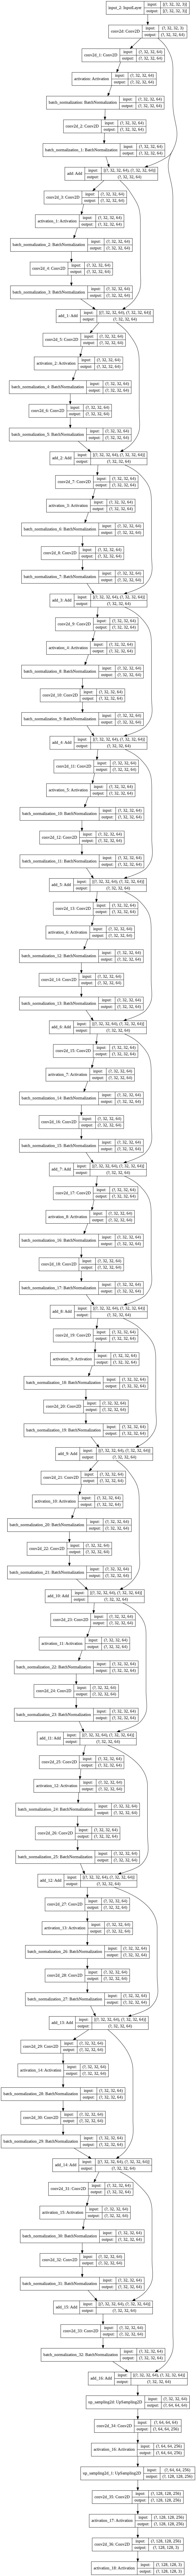

In [12]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

In [13]:
def build_discriminator():

  leakyrelu_alpha = 0.2
  momentum = 0.8

  input_shape = (128, 128, 3)

  input_layer = Input(shape=input_shape)

  dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
  dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

  dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
  dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
  dis2 = BatchNormalization(momentum=momentum)(dis2)

  dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
  dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
  dis3 = BatchNormalization(momentum=momentum)(dis3)

  dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
  dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
  dis4 = BatchNormalization(momentum=momentum)(dis4)

  dis5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(dis4)
  dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
  dis5 = BatchNormalization(momentum=momentum)(dis5)

  dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
  dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
  dis6 = BatchNormalization(momentum=momentum)(dis6)

  dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
  dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
  dis7 = BatchNormalization(momentum=momentum)(dis7)

  dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
  dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
  dis8 = BatchNormalization(momentum=momentum)(dis8)

  dis9 = Dense(units=1024)(dis8)
  dis9 = LeakyReLU(alpha=0.2)(dis9)

  output = Dense(units=1, activation='sigmoid')(dis9)

  model = Model(inputs=[input_layer], outputs=output, name='discriminator')

  return model



In [14]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer= common_optimizer, metrics=['accuracy'])

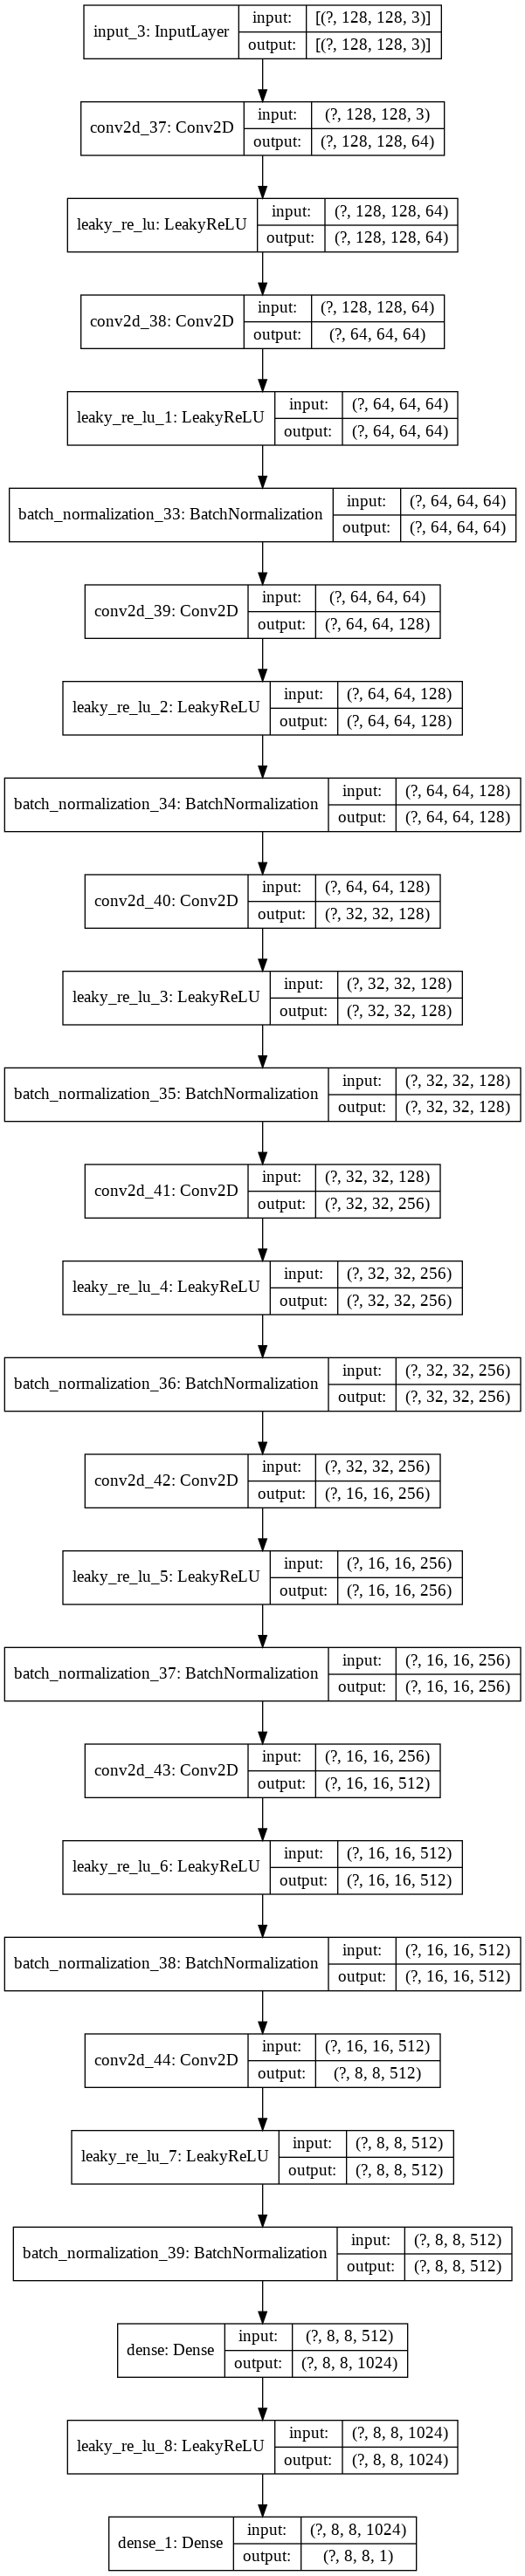

In [15]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [16]:
def build_adversarial_model(generator, discriminator, vgg):

  input_high_resolution = Input(shape=high_resolution_shape)

  input_low_resolution = Input(shape=low_resolution_shape)

  generated_high_resolution_images = generator(input_low_resolution)

  features = vgg(generated_high_resolution_images)

  discriminator.trainable = False
  discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

  probs = discriminator(generated_high_resolution_images)

  adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
  adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

  return adversarial_model

In [17]:
adversarial_model = build_adversarial_model(generator, discriminator, vgg)

In [18]:
def plot_loss(losses):

  d_loss = losses['d_history']
  g_loss = losses['g_history']

  plt.figure(figsize=(20, 8))
  plt.plot(d_loss, label="Discriminator Loss")
  plt.plot(g_loss, label="Generator Loss")

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [19]:
def calc_psnr2(original_image, generated_image):
  original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
  generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
  psnr2 = tf.image.psnr(original_image, generated_image, max_val=1.0)

  return tf.math.reduce_mean(psnr2, axis=None, keepdims=False, name=None)

In [20]:
def plot_psnr2(psnr2):
  psnr2_means = psnr2['psnr2_quality']
  plt.figure(figsize=(20,8))
  plt.plot(psnr2_means, label='PSNR Quality')
  plt.xlabel('Epochs')
  plt.ylabel('PSNR')
  plt.legend()
  plt.show()

In [21]:
def calc_ssim2(original_image, generated_image):
  original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
  generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
  ssim2 = tf.image.ssim(original_image, generated_image, max_val = 1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
  return tf.math.reduce_mean(ssim2, axis=None, keepdims=False, name=None)

In [22]:
def plot_ssim2(ssim2):
  ssim2_means = ssim2['ssim2_quality']
  plt.figure(figsize=(20,8))
  plt.plot(ssim2_means, label='SSIM Quanlity')
  plt.xlabel('Epochs')
  plt.ylabel('SSIM')
  plt.legend()
  plt.show()

In [23]:
psnr2 = {'psnr2_quality': []}
ssim2 = {'ssim2_quality': []}

In [24]:
losses = {'d_history':[], 'g_history':[]}

In [25]:
def sample_images(dir_data, batch_size, high_resolution_shape, low_resolution_shape):

  all_images = glob.glob(dir_data)

  images_batch = np.random.choice(all_images, size=batch_size)

  low_resolution_images = []
  high_resolution_images = []

  for img in images_batch:
    img1 = imread(img, as_gray=False, pilmode='RGB')
    img1 = img1.astype(np.float32)

    img1_high_resolution = imresize(img1, high_resolution_shape)
    img1_low_resolution = imresize(img1, low_resolution_shape)

    if np.random.random() < 0.5:
      img1_high_resolution = np.fliplr(img1_high_resolution)
      img1_low_resolution = np.fliplr(img1_low_resolution)

    high_resolution_images.append(img1_high_resolution)
    low_resolution_images.append(img1_low_resolution)

  return np.array(high_resolution_images), np.array(low_resolution_images)

In [26]:
def save_images(low_resolution_image, original_image, generated_image, epoch, index):
  
  fig = plt.figure(figsize=(15,10))

  ax = fig.add_subplot(1, 3, 1)
  ax.imshow(original_image)
  ax.axis("off")
  ax.set_title("ORIGINAL")

  ax = fig.add_subplot(1, 3, 2)
  ax.imshow(low_resolution_image)
  ax.axis("off")
  ax.set_title("LOW_RESOLUTION")

  ax = fig.add_subplot(1, 3, 3)
  ax.imshow(generated_image)
  ax.axis("off")
  ax.set_title("generated")

  plt.savefig("./saved/img_{}_{}.png".format(epoch, index))

In [ ]:
wandb.init(config=flags.FLAGS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: ignored

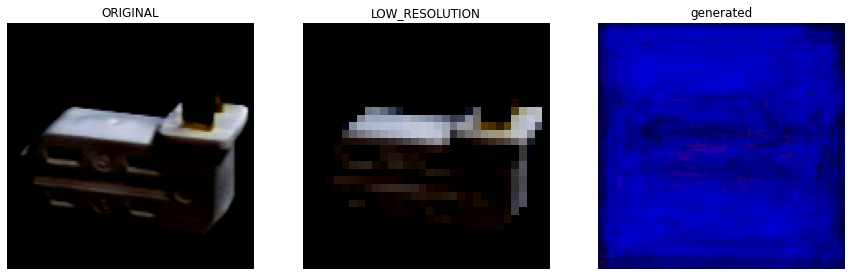

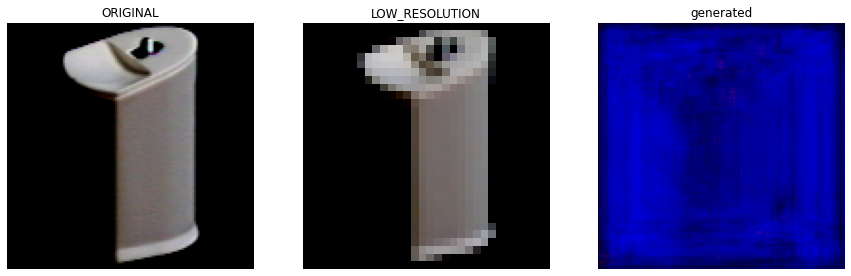

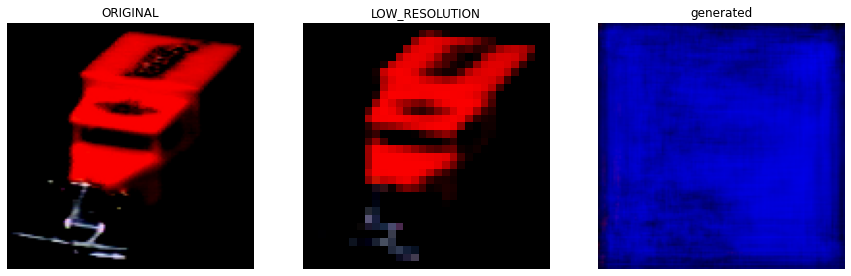

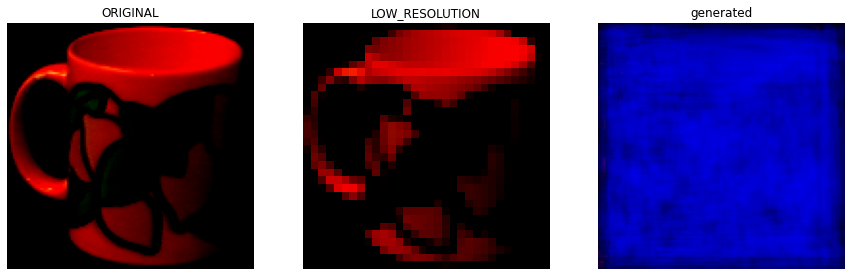

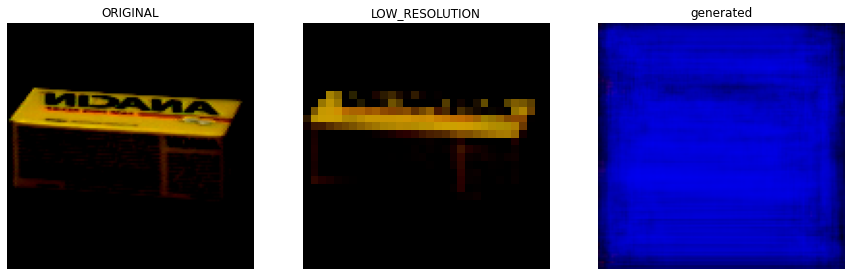

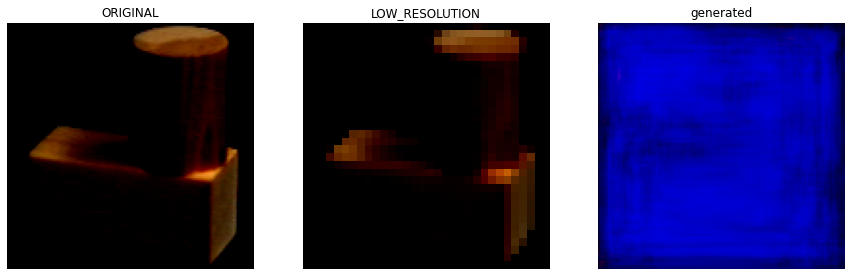

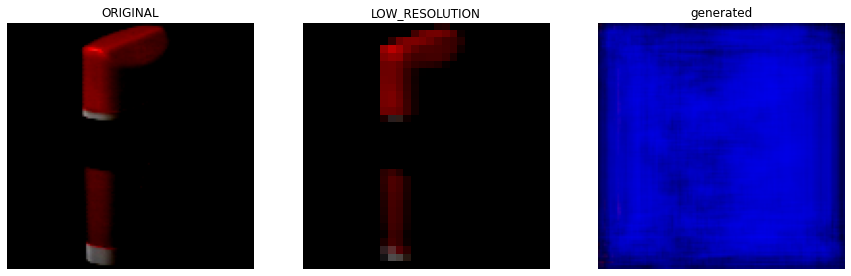

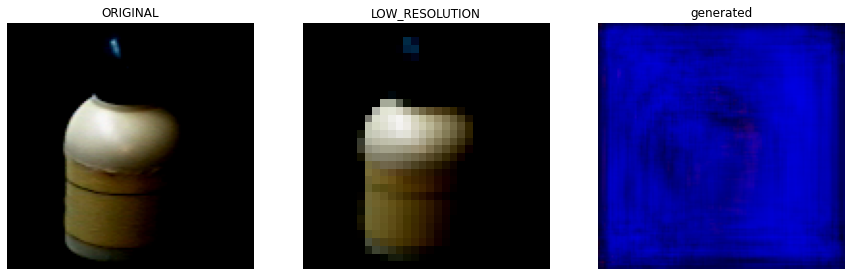

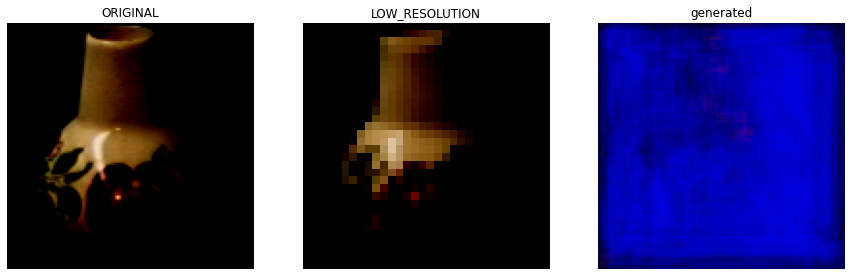

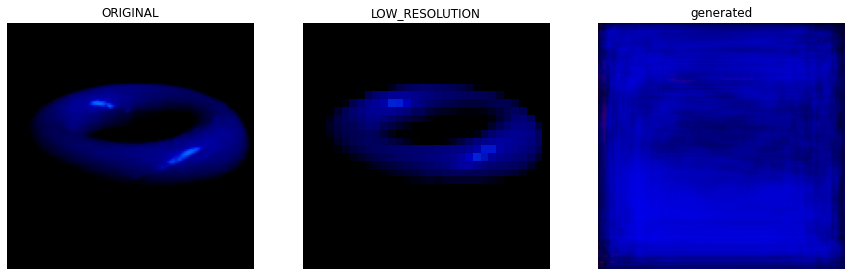

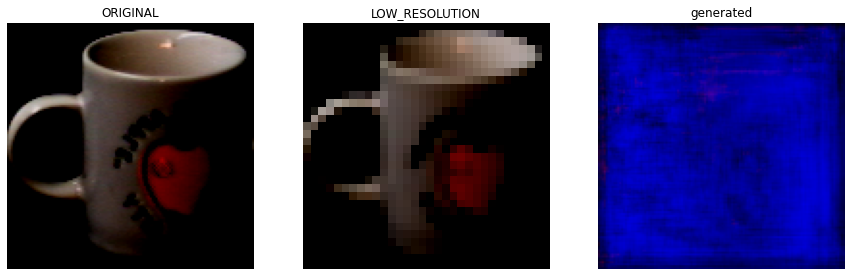

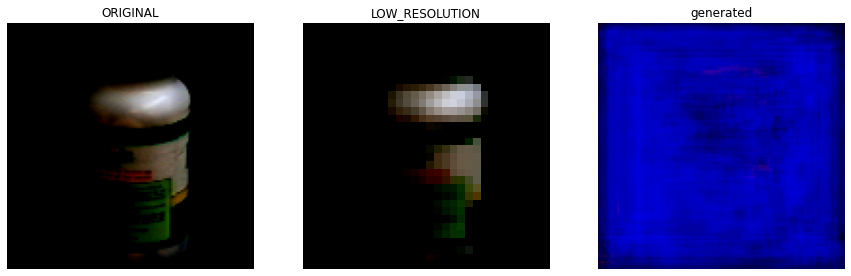

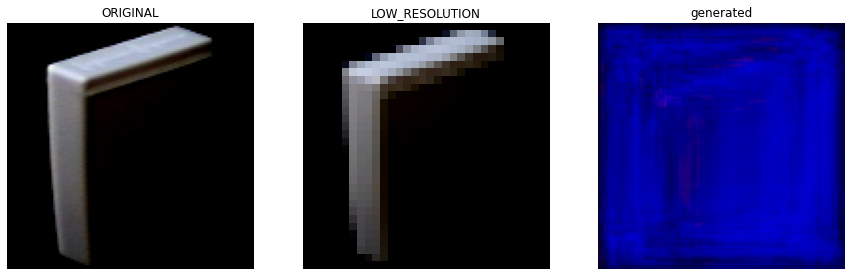

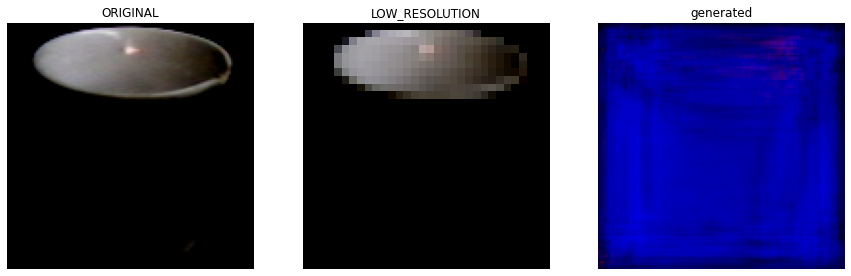

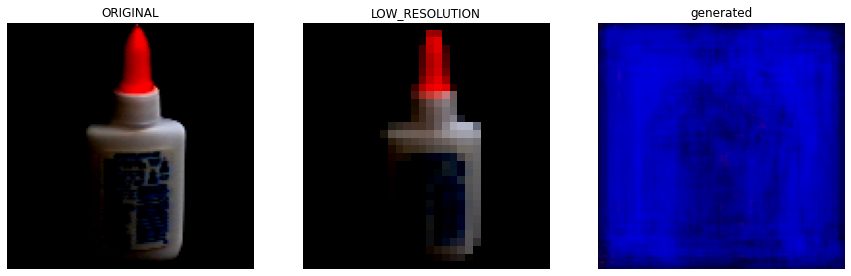

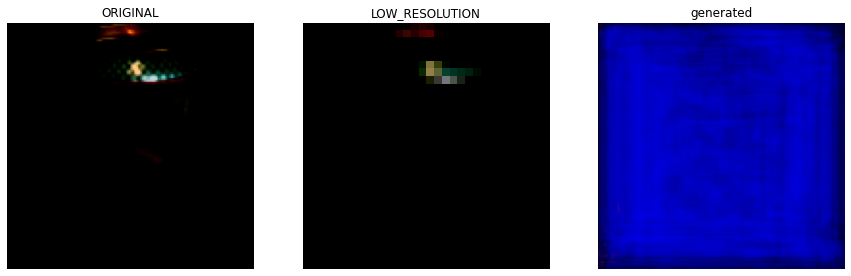

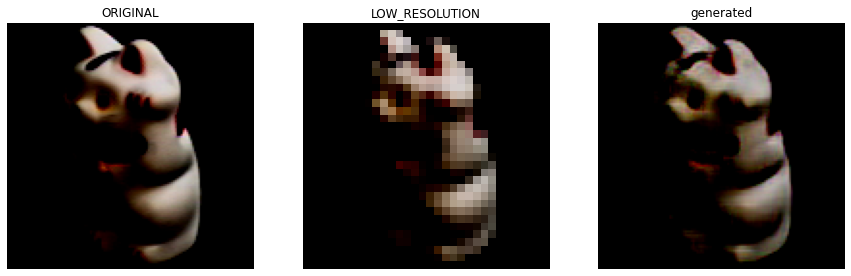

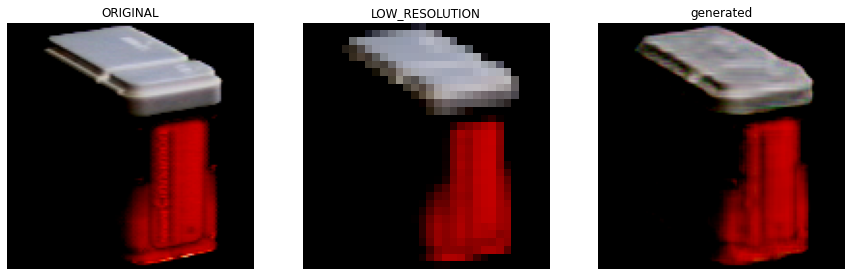

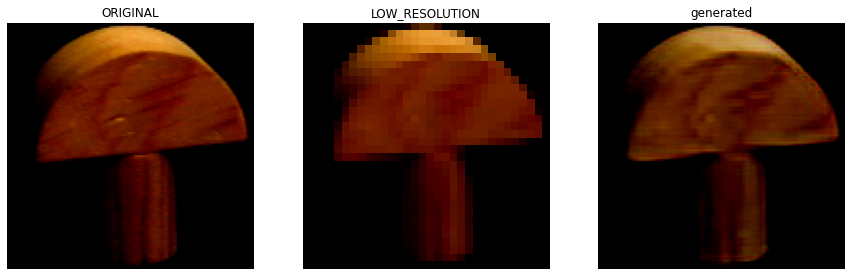

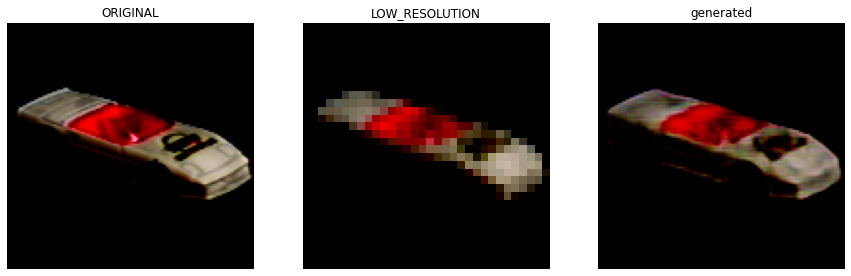

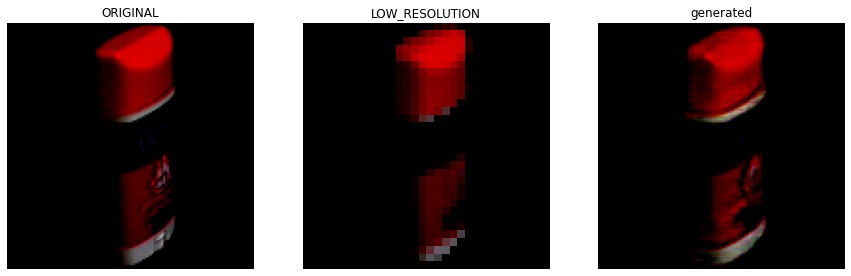

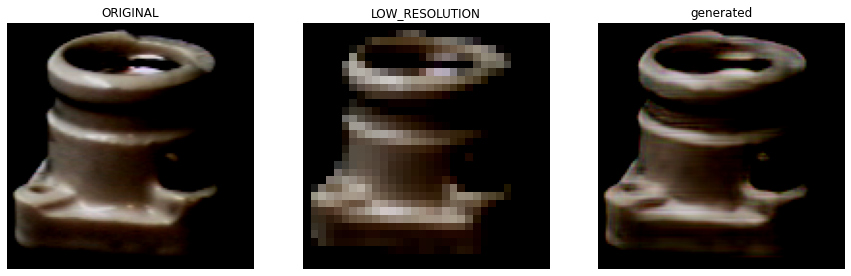

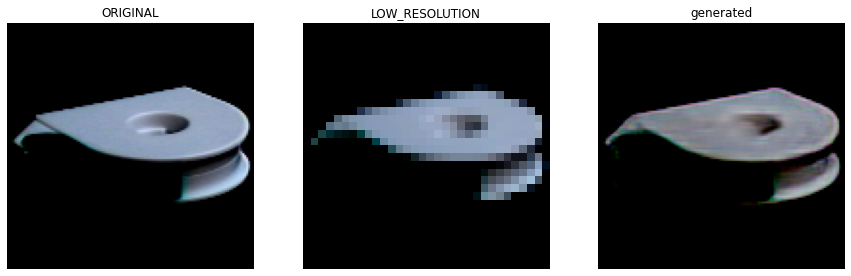

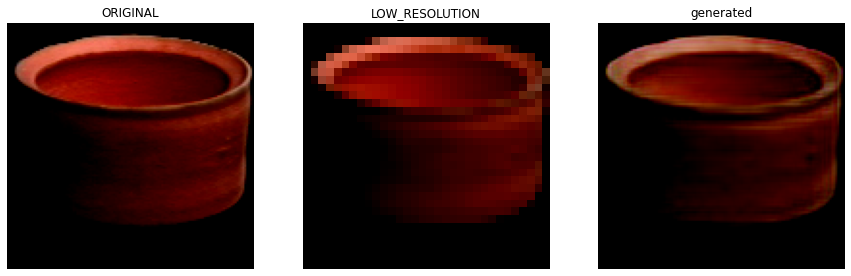

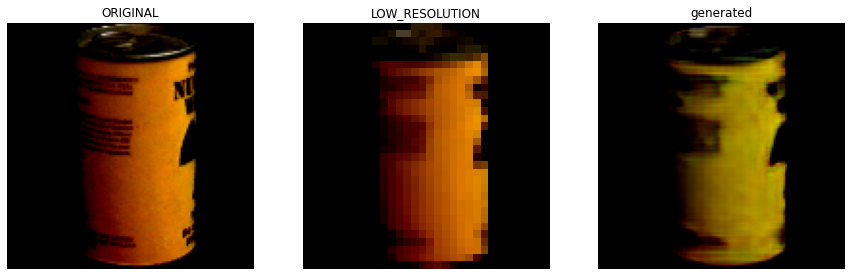

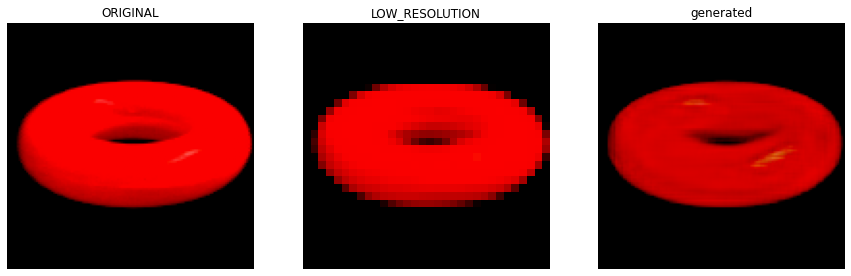

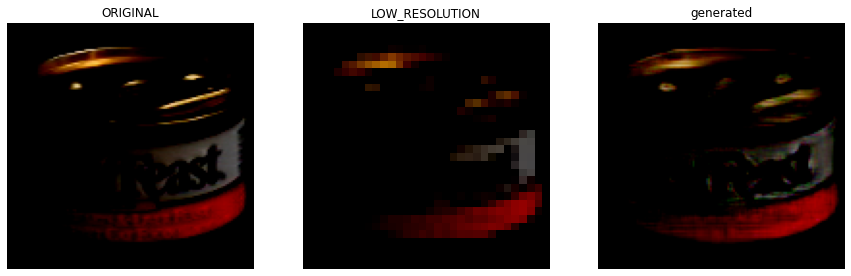

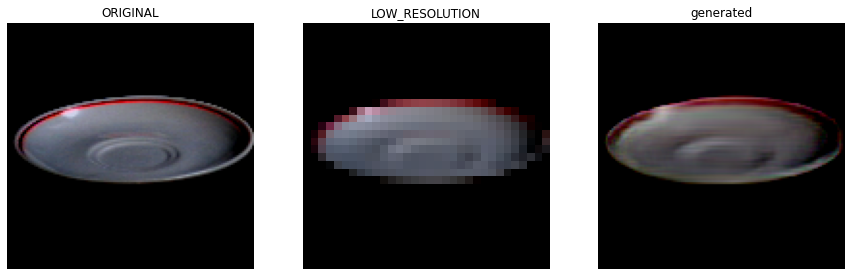

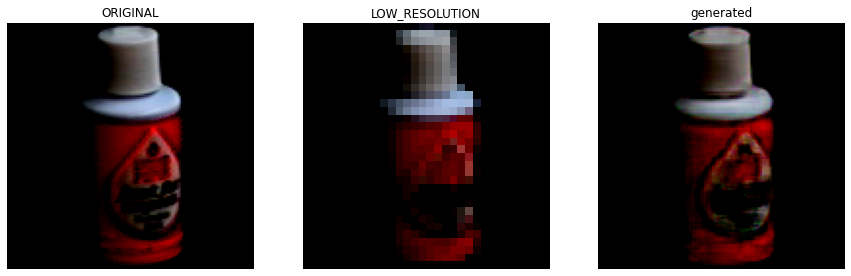

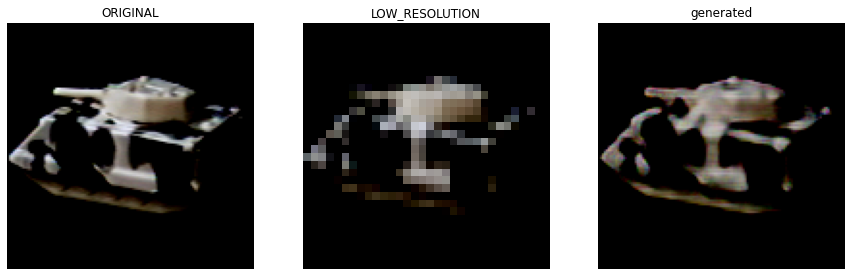

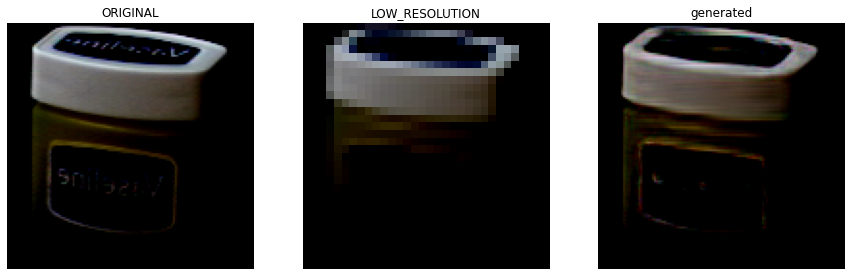

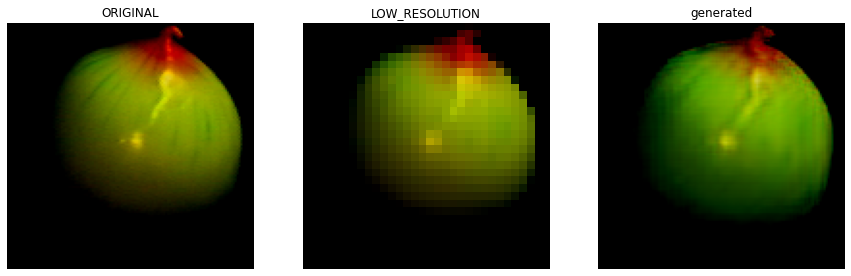

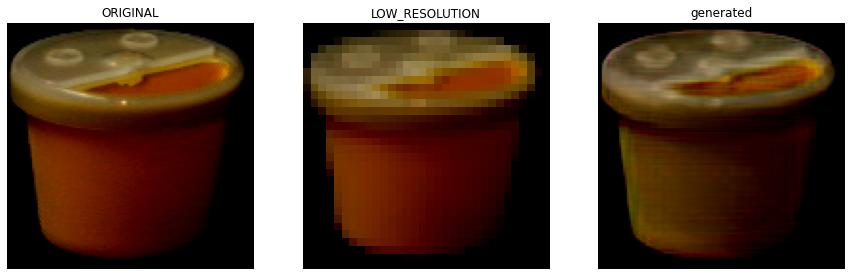

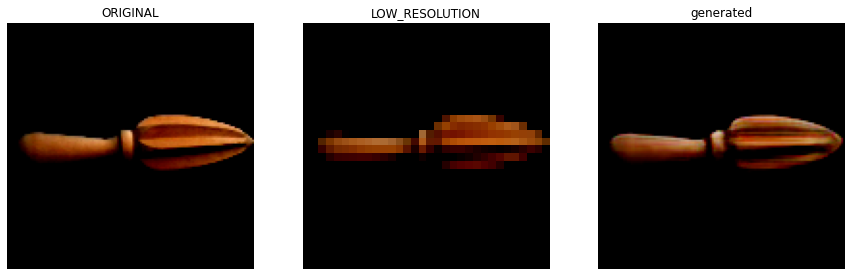

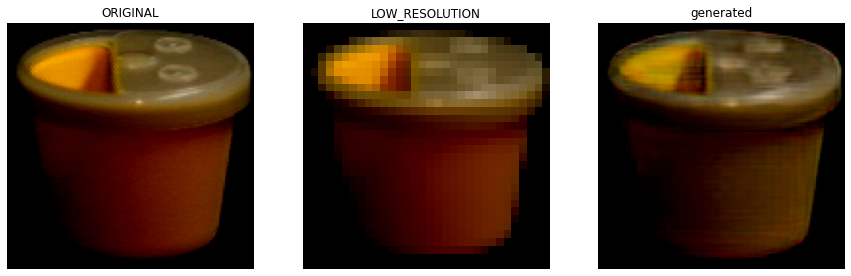

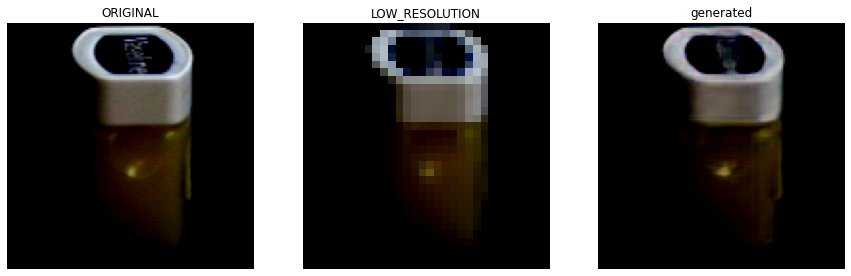

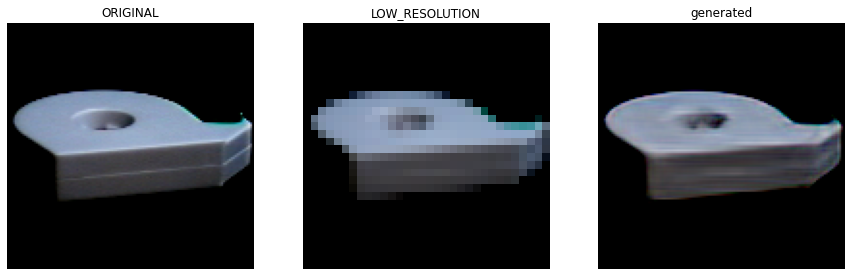

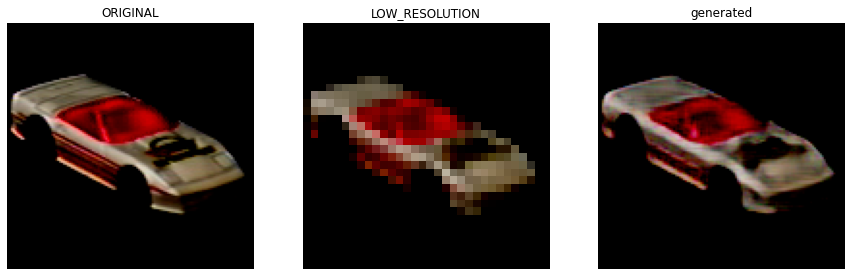

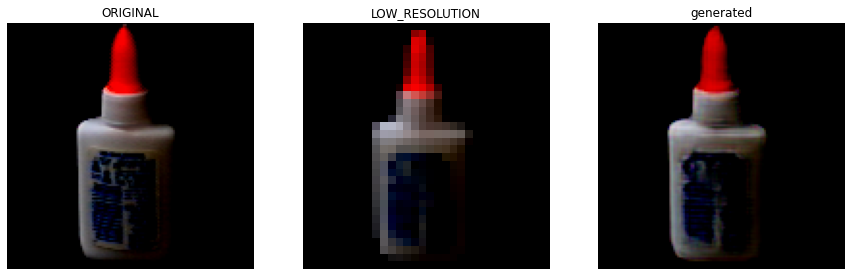

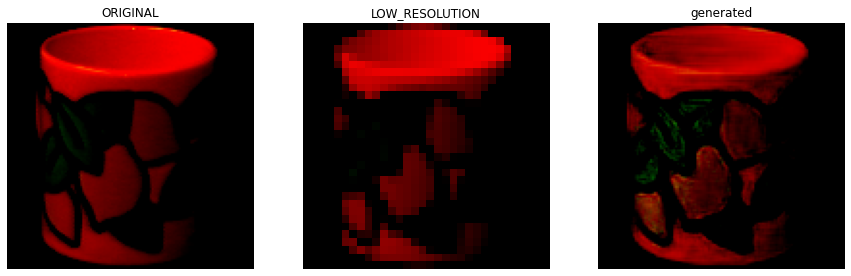

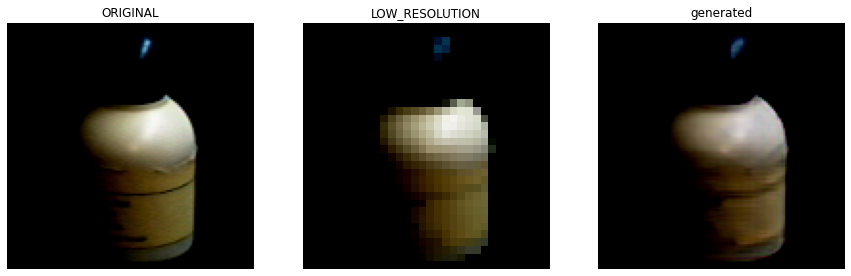

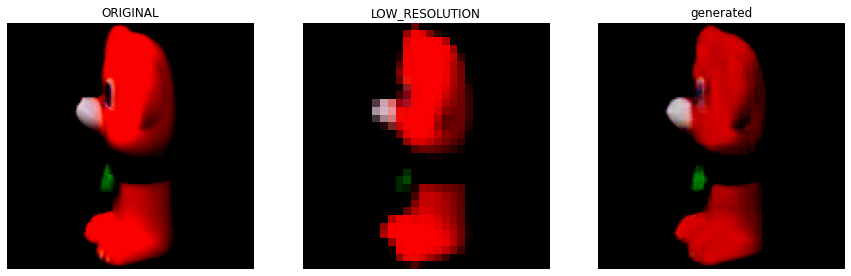

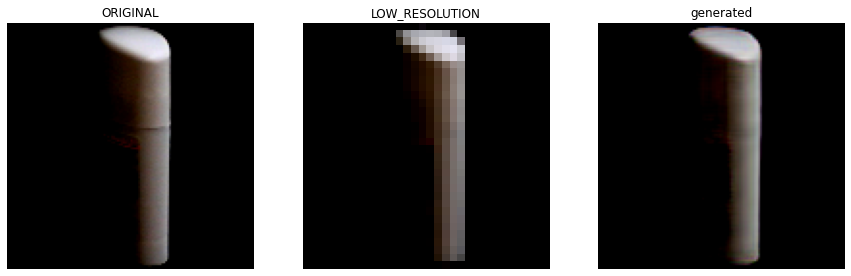

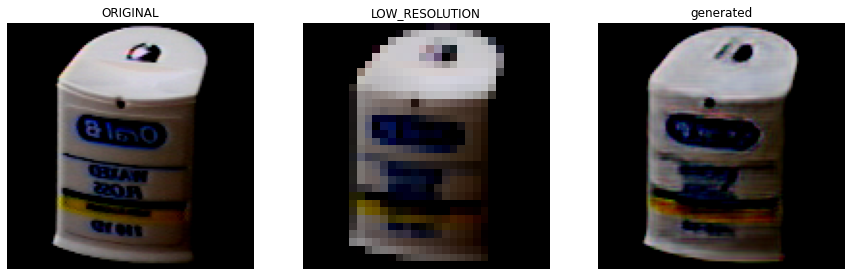

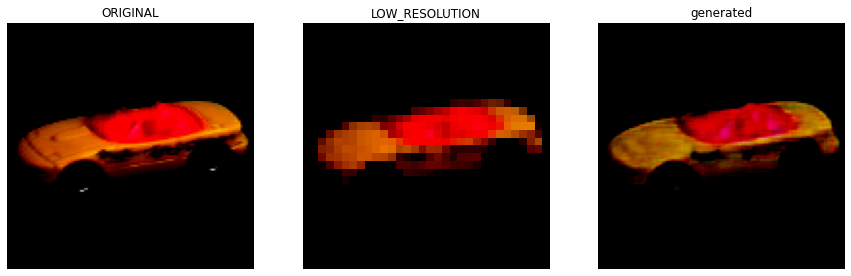

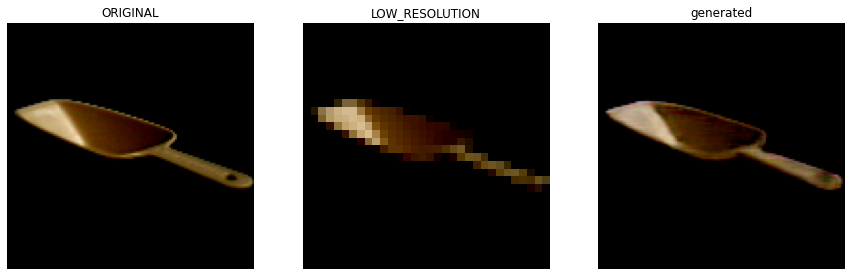

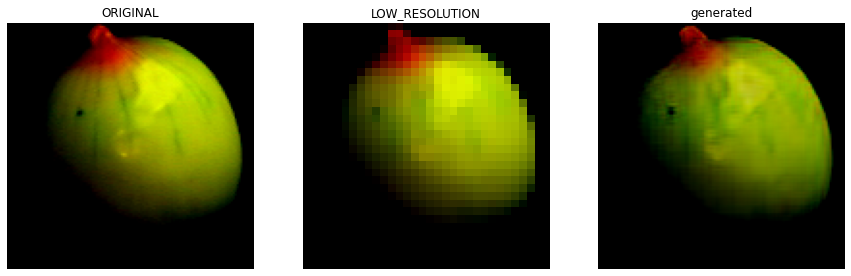

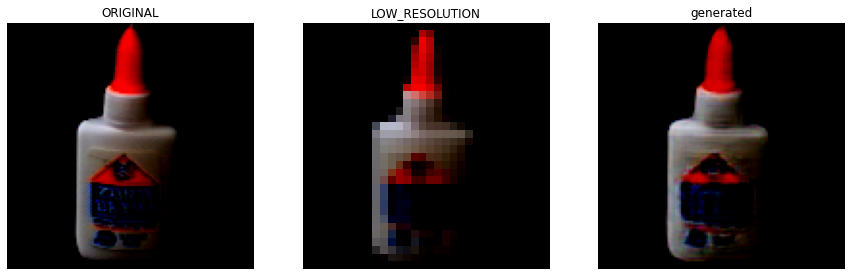

In [27]:
if not os.path.exists("./saved/"):
    os.makedirs("./saved/")
for epoch in range(epochs):

  d_history = []
  g_history = []

  high_resolution_images, low_resolution_images = sample_images(dir_data=dir_data, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)

  high_resolution_images = high_resolution_images/127.5 - 1.
  low_resolution_images = low_resolution_images/127.5 - 1.

  generated_high_resolution_images = generator.predict(low_resolution_images)

  real_labels = np.ones((batch_size, 8, 8, 1))
  fake_labels = np.zeros((batch_size, 8, 8, 1))

  d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
  d_loss_real = np.mean(d_loss_real)
  d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
  d_loss_fake = np.mean(d_loss_fake)

  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  losses['d_history'].append(d_loss)


  high_resolution_images, low_resolution_images = sample_images(dir_data=dir_data, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)

  high_resolution_images = high_resolution_images/127.5 - 1.
  low_resolution_images = low_resolution_images/127.5 - 1.

  image_features = vgg.predict(high_resolution_images)

  gfaces_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features])

  losses['g_history'].append(0.5 * (gfaces_loss[1]))

  ps2 = calc_psnr2(high_resolution_images, generated_high_resolution_images)
  psnr2['psnr2_quality'].append(ps2)

  ss2 = calc_ssim2(high_resolution_images, generated_high_resolution_images)
  ssim2['ssim2_quality'].append(ss2)

  wandb.log('Loss': losses, 'PSNR': psnr2, 'SSIM': ssim2)

  if epoch % 400 == 0:
    high_resolution_images, low_resolution_images = sample_images(dir_data=dir_data, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    
    high_resolution_images = high_resolution_images/127.5 - 1.
    low_resolution_images = low_resolution_images/127.5 - 1.

    generated_images = generator.predict_on_batch(low_resolution_images)

    for index, img in enumerate(generated_images):
      save_images(low_resolution_images[index], high_resolution_images[index], img, epoch, index)


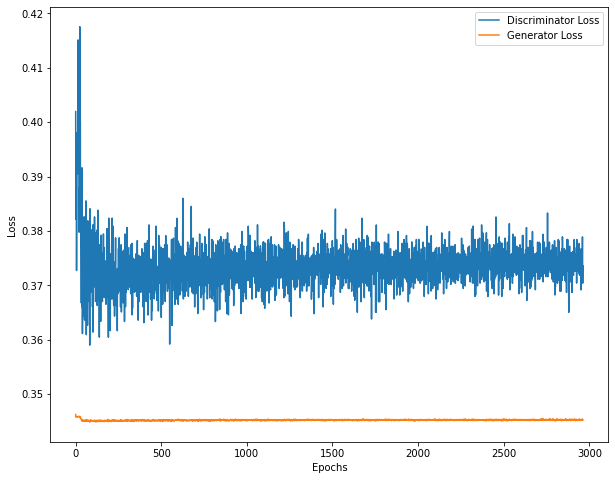

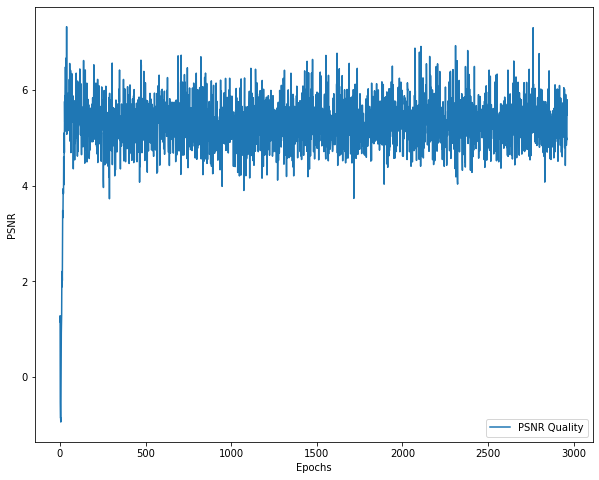

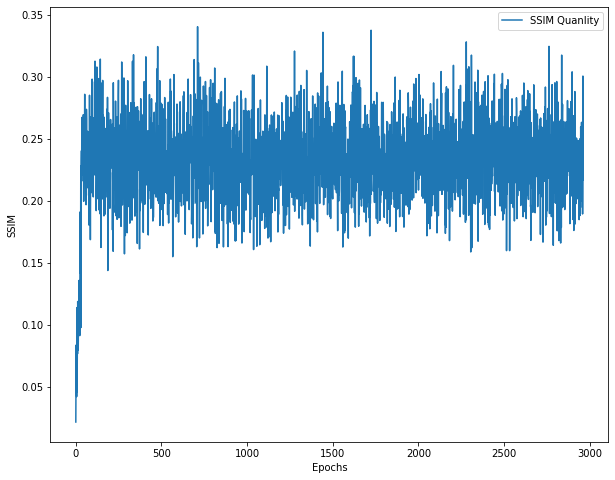

In [28]:
plot_loss(losses)
plot_psnr2(psnr2)
plot_ssim2(ssim2)

In [ ]:
frames = []
imgs = glob.glob("saved/*.png")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

 

frames[0].save('SRGAN_32-128', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=700, loop=0)